In [8]:
import matplotlib.pylab as plt
from scipy.stats import gaussian_kde
from scipy.special import erf
import numpy as np
import json
import sys
from matplotlib import style
style.use('../figures/plotting.mplstyle')

import numpyro
from numpyro.infer import NUTS,MCMC
from jax import random
import arviz as az
sys.path.append("./../code/numpyroCode/")
from demo_likelihoods import gaussianDemo

Open data from our set of spikeless injections. We'll focus on the injected catalog that most strongly (and hence most incorrectly) excludes $\zeta_\mathrm{spike}=0$, which is highlighted in the plot below.

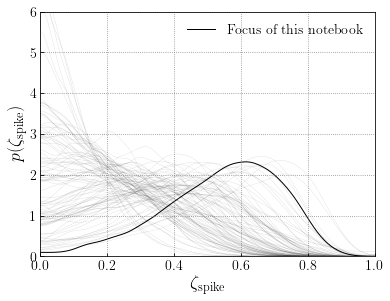

In [5]:
with open('../data/effective_spin_null_test.json','r') as jf:
    nullData = json.load(jf)
    
# Plot results to highlight the catalog of interest
fig,ax = plt.subplots(figsize=(6,4.5))
grid = np.linspace(0,1,100)

# Loop across mock catalogs from null test
for catalog,result in nullData.items():
    
    # From each catalog, extract spike samples, KDE, and plot
    zeta_null_samples = result['posteriors']['zeta_spike']
    null_kde = gaussian_kde(zeta_null_samples,bw_method='scott')
    if catalog=='13':
        ax.plot(grid,null_kde(grid) + null_kde(2.-grid) + null_kde(-grid),color='black',alpha=1,lw=1,zorder=0,
               label='Focus of this notebook')
    else:
        ax.plot(grid,null_kde(grid) + null_kde(2.-grid) + null_kde(-grid),color='black',alpha=0.15,lw=0.35,zorder=0)
        
ax.set_xlim(0,1)
ax.set_ylim(0,6)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'$\zeta_\mathrm{spike}$',fontsize=18)
ax.set_ylabel(r'$p(\zeta_\mathrm{spike})$',fontsize=18)
ax.axes.grid(True,which='major',ls=':',color='grey')
ax.legend()
plt.show()

Plot the individual mock events that went into this catalog:

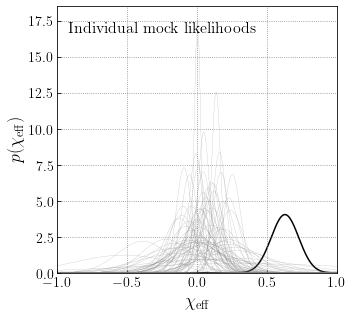

In [56]:
# Get the catalog instantiation in question
catalog = nullData['13']['catalog']

def gaussian(samples,mu,sigma,lowCutoff,highCutoff):
    
    """
    Function defining the probability density due to a truncated Gaussian
    """
    
    a = (lowCutoff-mu)/np.sqrt(2*sigma**2)
    b = (highCutoff-mu)/np.sqrt(2*sigma**2)
    norm = np.sqrt(sigma**2*np.pi/2)*(-erf(a) + erf(b))
    return np.exp(-(samples-mu)**2/(2.*sigma**2))/norm

fig,ax = plt.subplots(figsize=(5,4.5))
x_grid = np.linspace(-1,1,300)

for eventNumber,event in catalog.items():
    
    if event['x_ml']>0.5:
        ax.plot(x_grid,gaussian(x_grid,event['x_ml'],event['sig_obs'],-1,1),color='black',zorder=0)
    else:
        ax.plot(x_grid,gaussian(x_grid,event['x_ml'],event['sig_obs'],-1,1),color='grey',lw=0.2,alpha=0.75)
    
ax.set_rasterization_zorder(1)
ax.set_xlim(-1,1)
ax.set_ylim(bottom=0)
ax.set_xlabel(r'$\chi_\mathrm{eff}$')
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$')
ax.text(-0.92,16.7,'Individual mock likelihoods',fontsize=16)

plt.tight_layout()
plt.savefig('figure_11a.pdf',bbox_inches='tight',dpi=200)
plt.show()

Plot the joint $\zeta_\mathrm{spike}$ vs $\mu_\mathrm{eff}$ posterior from this catalog:

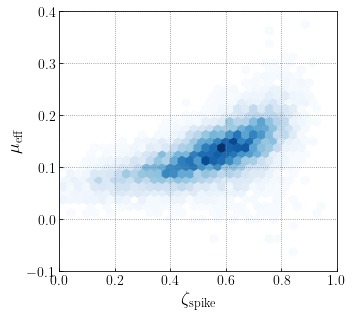

In [55]:
fig,ax = plt.subplots(figsize=(5,4.5))
ax.hexbin(nullData['13']['posteriors']['zeta_spike'],nullData['13']['posteriors']['mu'],
          cmap='Blues',gridsize=35,mincnt=1,extent=(0,1,-0.1,0.4),zorder=1)
ax.set_xlim(0,1)
ax.set_ylim(-0.1,0.4)
ax.set_xlabel(r'$\zeta_\mathrm{spike}$')
ax.set_ylabel(r'$\mu_\mathrm{eff}$')
ax.set_rasterization_zorder(2)

plt.tight_layout()
plt.savefig('figure_11b.pdf',bbox_inches='tight',dpi=200)
plt.show()

Re-run inference but without the event highlighted above.

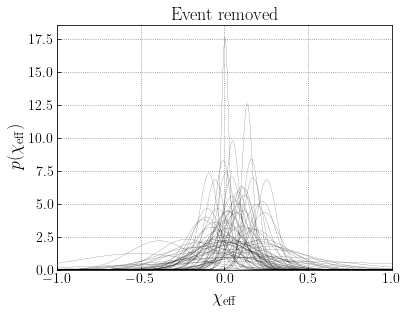

In [24]:
# Find the location of the event with the largest mean
mus = [catalog[event]['x_ml'] for event in catalog]
to_remove = np.argmax(mus)

# Remove
new_cat = catalog.copy()
new_cat.pop(str(to_remove))

# Replot to verify that the intended event is now absent!
fig,ax = plt.subplots()
x_grid = np.linspace(-1,1,300)
for eventNumber,event in new_cat.items():
    ax.plot(x_grid,gaussian(x_grid,event['x_ml'],event['sig_obs'],-1,1),color='black',lw=0.2,alpha=0.75)
    ax.set_xlim(-1,1)
ax.set_ylim(bottom=0)
ax.set_xlabel(r'$\chi_\mathrm{eff}$')
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$')
ax.set_title('Event removed',fontsize=18)
plt.show()

In [31]:
# Rerun inference
# Run over several chains to check convergence
nChains = 3
numpyro.set_host_device_count(nChains)

# Set RNG seeds
rng_key = random.PRNGKey(0)

# Run inference
kernel = NUTS(gaussianDemo)
mcmc = MCMC(kernel,num_warmup=300,num_samples=3000,num_chains=nChains)

rng_key,rng_key_ = random.split(rng_key)
mcmc.run(rng_key_,new_cat)
mcmc.print_summary()

# Extract posterior chains
data = az.from_numpyro(mcmc)
stacked_samples = data.posterior.stack(draws=("chain", "draw"))

  0%|          | 0/3300 [00:00<?, ?it/s]

  0%|          | 0/3300 [00:00<?, ?it/s]

  0%|          | 0/3300 [00:00<?, ?it/s]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
  logit_zeta_spike     -0.21      1.07     -0.04     -1.69      1.35   1115.49      1.00
        logsig_chi     -1.27      0.14     -1.28     -1.50     -1.08   3594.31      1.00
            mu_chi      0.10      0.03      0.10      0.05      0.16   2363.27      1.00

Number of divergences: 0


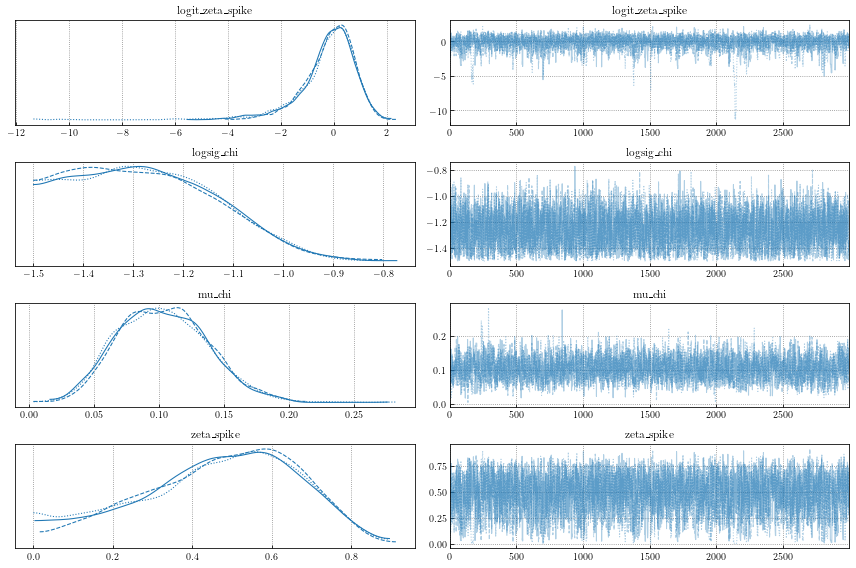

In [32]:
az.plot_trace(data, compact=True)
plt.tight_layout()
plt.show()

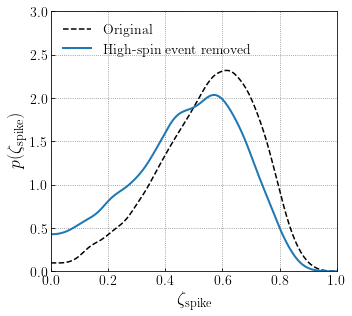

In [54]:
# Plot posteriors on zetaSpike with and without the high-spin event included
fig,ax = plt.subplots(figsize=(5,4.5))

# KDE samples
kde_original = gaussian_kde(nullData['13']['posteriors']['zeta_spike'],bw_method='scott')
kde_rerun = gaussian_kde(stacked_samples.zeta_spike,bw_method='scott')
grid = np.linspace(0,1,200)

# Plot KDEs
# Note that we're imposing symmetric boundary conditions at 0 and 1
ax.plot(grid,kde_original(grid) + kde_original(-grid) + kde_original(2.-grid),ls='--',
        color='black',label='Original')
ax.plot(grid,kde_rerun(grid) + kde_rerun(-grid) + kde_rerun(2.-grid),lw=2,
        label='High-spin event removed')

# Misc
ax.legend(loc='upper left')
ax.set_xlim(0,1)
ax.set_ylim(0,3)
ax.set_xlabel(r'$\zeta_\mathrm{spike}$')
ax.set_ylabel(r'$p(\zeta_\mathrm{spike})$')
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('figure_11c.pdf',bbox_inches='tight')
plt.show()